In [2]:
import os
os.chdir('/glade/work/yifanc17/01_scripts/03_urban_resolving_CESM/scripts/utils/')

In [3]:
from load_sim_data import *
from load_shp import *
from sim_eval_pkg import *

Updated on 2025-10-05


___

### Figure 9a

___

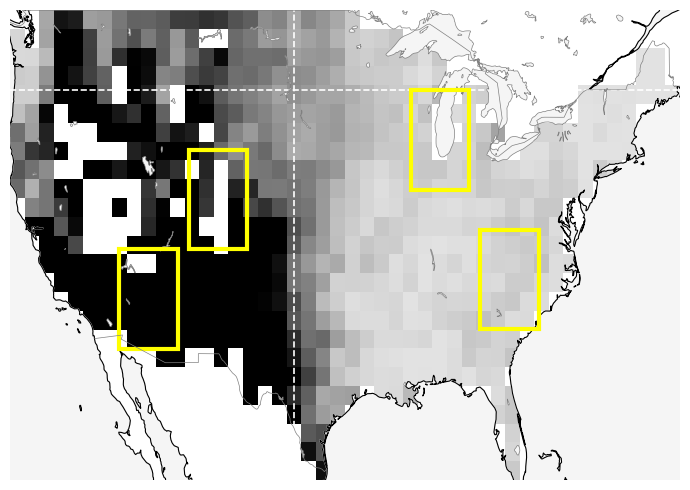

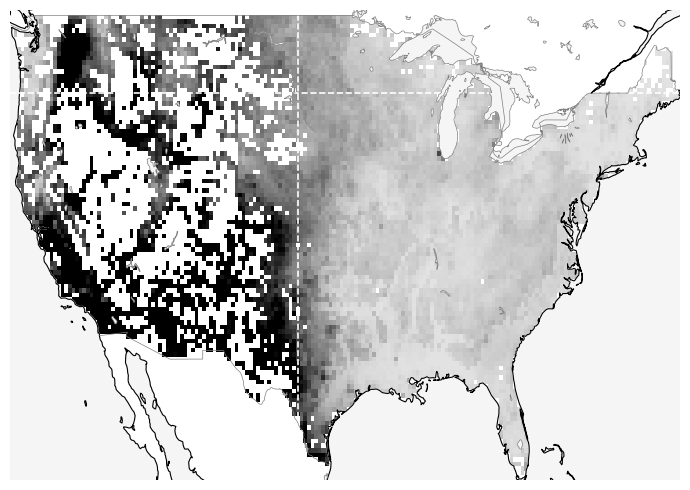

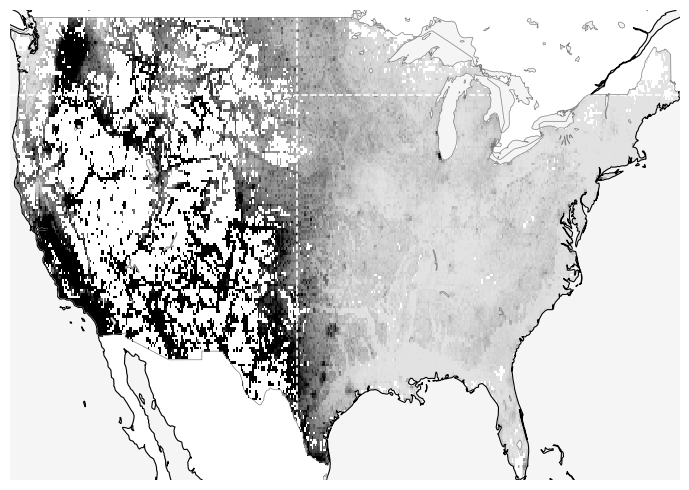

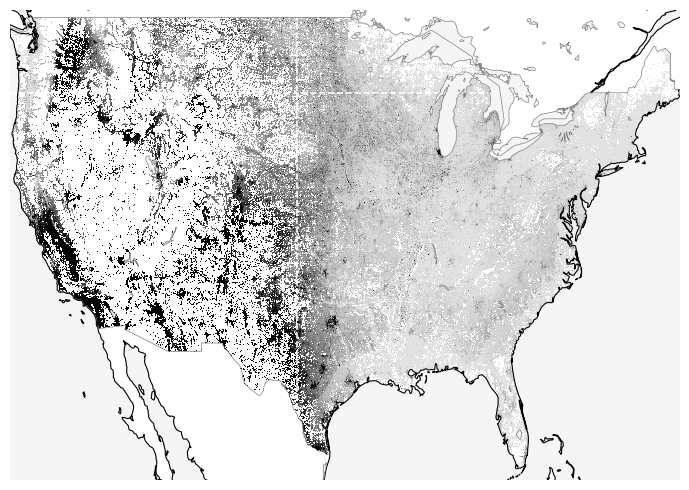

In [5]:
for res in ['1deg','025deg','14km','1d32deg']:
    fig, ax = plt.subplots(figsize=(7,5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
    vmin = 0.1
    vmax = 2
    conus_extent = [-125, -66.5, 24, 50]
    rect_colors = ['green','blue','orange','red']
    for spine in ax.spines.values():
        spine.set_visible(False)
    fg = eval(f'bowen_ratio_{res}').plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=greys_truncated, 
        vmax=vmax,
        vmin=vmin,
        alpha=1,
        add_colorbar=False
    )
    if res == '1deg':
        for i, (key, val) in enumerate(regions.items()):
            lon0 = val['lon'].start
            lon1 = val['lon'].stop
            lat0 = val['lat'].start
            lat1 = val['lat'].stop
            
            width = lon1 - lon0
            height = lat1 - lat0
            
            rect = Rectangle((lon0, lat0), width, height,
                             linewidth=3, edgecolor='yellow', facecolor='none',
                             transform=ccrs.PlateCarree(),zorder=100)
            ax.add_patch(rect)
    
    ax.coastlines(color='black', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=150)
    
    gl = ax.gridlines(draw_labels=False, color='white', linewidth=1.2, linestyle='--', zorder=3)
    gl.xlocator = plt.FixedLocator([-100, 0, 100])
    gl.ylocator = plt.FixedLocator([-90, -45, 0, 45, 90])
    
    ax.add_feature(cfeature.OCEAN, color='whitesmoke', zorder=1)
    ax.add_feature(cfeature.LAKES, edgecolor='gray', facecolor='whitesmoke', linewidth=0.5, zorder=50)
    ax.set_title('') 
    ax.set_aspect('auto')
    plt.tight_layout()

___

### Figure 9c

___

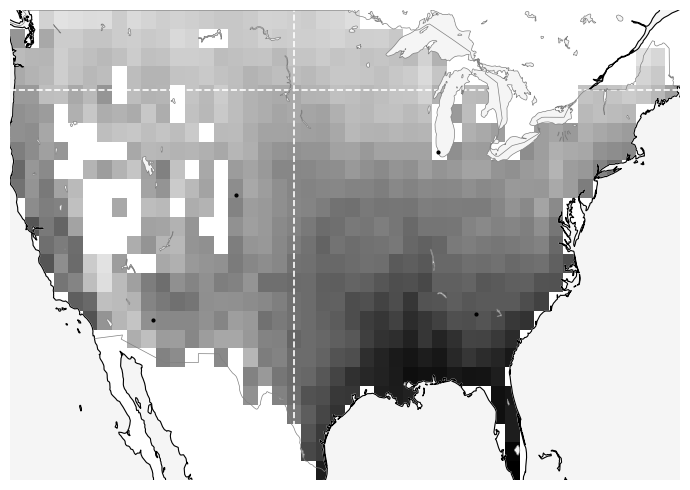

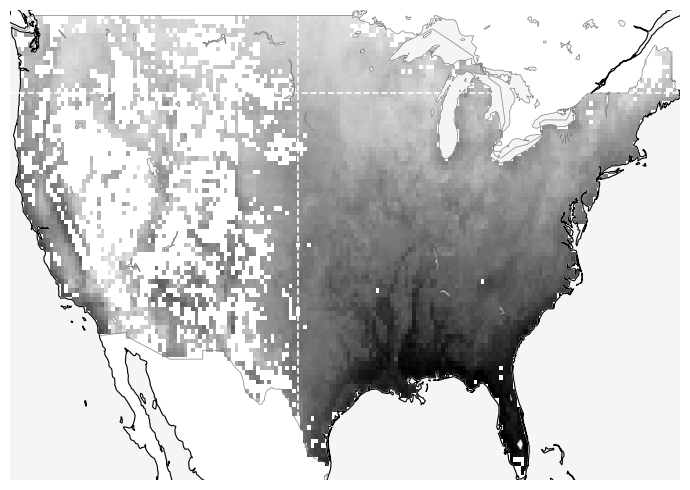

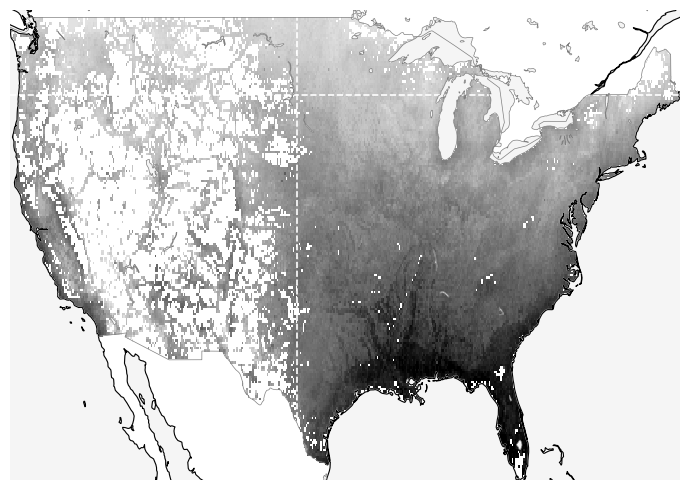

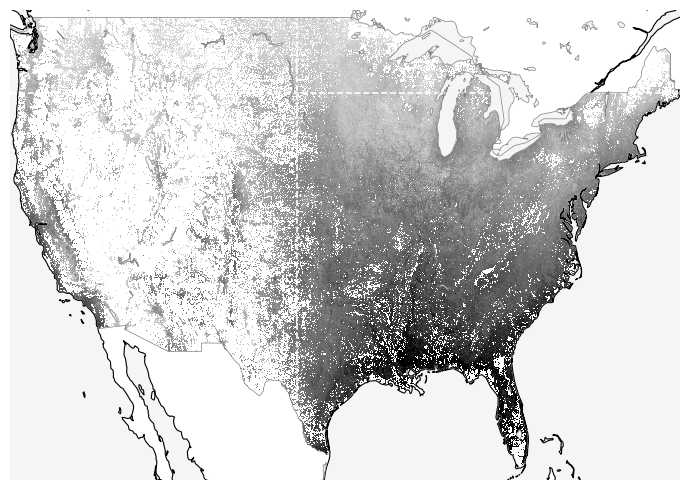

In [17]:
for res in ['1deg','025deg','14km','1d32deg']:
    fig, ax = plt.subplots(figsize=(7,5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
    vmin = 50
    vmax = 110
    conus_extent = [-125, -66.5, 24, 50]
    rect_colors = ['green','blue','orange','red']
    for spine in ax.spines.values():
        spine.set_visible(False)
    fg = eval(f'net_radiation_{res}').plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=greys_truncated, 
        vmax=vmax,
        vmin=vmin,
        alpha=1,
        add_colorbar=False
    )
    if res == '1deg':
        for name, coord in cities.items():
            ax.plot(coord['lon'], coord['lat'],
                    marker='o',
                    markersize=2,
                    color='black',
                    transform=ccrs.PlateCarree(),
                    zorder=300)
    
    ax.coastlines(color='black', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=150)
    
    gl = ax.gridlines(draw_labels=False, color='white', linewidth=1.2, linestyle='--', zorder=3)
    gl.xlocator = plt.FixedLocator([-100, 0, 100])
    gl.ylocator = plt.FixedLocator([-90, -45, 0, 45, 90])
    
    ax.add_feature(cfeature.OCEAN, color='whitesmoke', zorder=1)
    ax.add_feature(cfeature.LAKES, edgecolor='gray', facecolor='whitesmoke', linewidth=0.5, zorder=50)
    ax.set_title('') 
    ax.set_aspect('auto')
    plt.tight_layout()

___

### Figure 9b[1] & 9d[1]

___

In [4]:
def compute_spatial_spectrum(da: xr.DataArray):
    data = da.fillna(0).values
    data = data - np.mean(data[~np.isnan(da.values)])
    
    fft2d = np.fft.fft2(data)
    power = np.abs(fft2d)**2
    
    dx = float(da.lon[1] - da.lon[0])
    dy = float(da.lat[1] - da.lat[0])
    # wavenumber k=2pi*lambda (wavelength)
    kx = 2*np.pi*np.fft.fftfreq(da.shape[1], dx)
    ky = 2*np.pi*np.fft.fftfreq(da.shape[0], dy)
    
    kxx, kyy = np.meshgrid(kx, ky)
    k_magnitude = np.sqrt(kxx**2 + kyy**2)
    
    k_bins = np.logspace(np.log10(k_magnitude[k_magnitude > 0].min()), 
                        np.log10(k_magnitude.max()), 50)
    k_centers = np.sqrt(k_bins[1:] * k_bins[:-1])
    
    power_binned = np.zeros_like(k_centers)
    for i in range(len(k_centers)):
        mask = (k_magnitude >= k_bins[i]) & (k_magnitude < k_bins[i+1])
        if mask.any():
            power_binned[i] = power[mask].mean()
    
    valid = power_binned > 0
    return k_centers[valid], power_binned[valid]

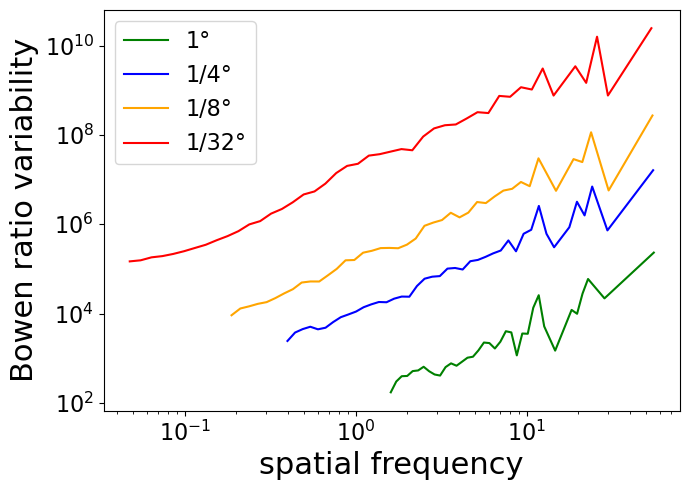

In [24]:
fig, ax = plt.subplots(figsize=(7,5))
index=0
resolution_colors = ['green','blue','orange','red'] 
for da, label in zip([bowen_ratio_1deg,bowen_ratio_025deg,bowen_ratio_14km,bowen_ratio_1d32deg], 
                    ['1°', '1/4°', '1/8°', '1/32°']):
    k, power = compute_spatial_spectrum(da)
    ax.loglog(2*np.pi/k, power, label=label,color=resolution_colors[index]) 
    index += 1

ax.set_xlabel('spatial frequency',fontsize=22)
ax.set_ylabel('Bowen ratio variability',fontsize=22)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_yticks([1e2, 1e4, 1e6, 1e8, 1e10]) 
ax.yaxis.set_minor_locator(plt.NullLocator())
# ax.get_yaxis().set_major_formatter(plt.ScalarFormatter()) 
ax.legend(fontsize=16)
plt.tight_layout()

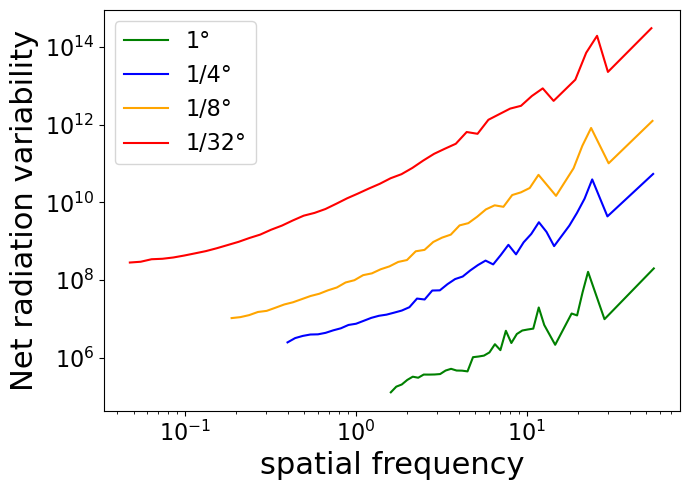

In [25]:
fig, ax = plt.subplots(figsize=(7,5))
index=0
resolution_colors = ['green','blue','orange','red'] 
for da, label in zip([net_radiation_1deg,net_radiation_025deg,net_radiation_14km,net_radiation_1d32deg], 
                    ['1°', '1/4°', '1/8°', '1/32°']):
    k, power = compute_spatial_spectrum(da)
    ax.loglog(2*np.pi/k, power, label=label,color=resolution_colors[index]) 
    index += 1

ax.set_xlabel('spatial frequency',fontsize=22)
ax.set_ylabel('Net radiation variability',fontsize=22)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize=16)
plt.tight_layout()

___

### Figure 9b[2] & 9d[2]

___

In [7]:
window_1deg = 3    # ~100km
window_14deg = 12  # ~25km
window_18deg = 24  # ~14km 
window_132deg = 96 # ~3.5km

In [8]:
bowen_ratio_cv_stats=[]
bowen_ratio_cv_1deg=bowen_ratio_cv_dict['1deg'][~np.isnan(bowen_ratio_cv_dict['1deg'])]
bowen_ratio_cv_1deg=bowen_ratio_cv_1deg[bowen_ratio_cv_1deg!=0.0]
bowen_ratio_cv_14deg=bowen_ratio_cv_dict['1/4deg'][~np.isnan(bowen_ratio_cv_dict['1/4deg'])]
bowen_ratio_cv_14deg=bowen_ratio_cv_14deg[bowen_ratio_cv_14deg!=0.0]
bowen_ratio_cv_18deg=bowen_ratio_cv_dict['1/8deg'][~np.isnan(bowen_ratio_cv_dict['1/8deg'])]
bowen_ratio_cv_18deg=bowen_ratio_cv_18deg[bowen_ratio_cv_18deg!=0.0]
bowen_ratio_cv_132deg=bowen_ratio_cv_dict['1/32deg'][~np.isnan(bowen_ratio_cv_dict['1/32deg'])]
bowen_ratio_cv_132deg=bowen_ratio_cv_132deg[bowen_ratio_cv_132deg!=0.0]
bowen_ratio_cv_stats.append(bowen_ratio_cv_1deg)
bowen_ratio_cv_stats.append(bowen_ratio_cv_14deg)
bowen_ratio_cv_stats.append(bowen_ratio_cv_18deg)
bowen_ratio_cv_stats.append(bowen_ratio_cv_132deg)

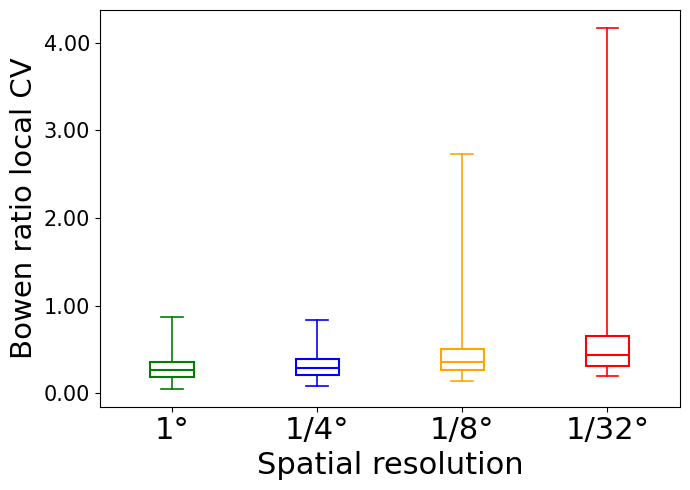

In [20]:
plt.figure(figsize=(7,5))
box = plt.boxplot(bowen_ratio_cv_stats, patch_artist=True, widths=0.3, showfliers=False, whis=[1,99])
resolutions = ['1°', '1/4°', '1/8°', '1/32°']
resolution_colors = ['green','blue','orange','red'] 
resolution_labels = [f'1° ({window_1deg}x{window_1deg})', 
                     f'1/4° ({window_14deg}x{window_14deg})',
                         f'1/8° ({window_18deg}x{window_18deg})', 
                         f'1/32° ({window_132deg}x{window_132deg})']
x_positions = range(1, len(bowen_ratio_cv_stats) + 1) 
for i, patch in enumerate(box['boxes']):
    resolution_color = resolution_colors[i % 4]  
    patch.set_facecolor('none') 
    patch.set_edgecolor(resolution_color)
    patch.set_linewidth(1.5)

for i, (whisker, cap) in enumerate(zip(box['whiskers'], box['caps'])):
    resolution_color = resolution_colors[(i // 2) % 4]
    whisker.set_color(resolution_color)
    whisker.set_linewidth(1.2)
    cap.set_color(resolution_color)
    cap.set_linewidth(1.2)

for i, median in enumerate(box['medians']):
    resolution_color = resolution_colors[i % 4]
    median.set_color(resolution_color)
    median.set_linewidth(1.5)

import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(edgecolor=color, label=res, fill=False) for color, res in zip(resolution_colors, resolution_labels)]
# plt.legend(handles=legend_patches, loc='upper left',fontsize=14)
from matplotlib.ticker import FormatStrFormatter

ax = plt.gca() 
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xticks(x_positions,resolutions,fontsize=22)
plt.yticks(fontsize=15)
plt.xlabel('Spatial resolution',fontsize=22)
plt.ylabel('Bowen ratio local CV',fontsize=21)
plt.tight_layout()

In [10]:
net_radiation_cv_stats=[]
net_radiation_cv_1deg=net_radiation_cv_dict['1deg'][~np.isnan(net_radiation_cv_dict['1deg'])]
net_radiation_cv_1deg=net_radiation_cv_1deg[net_radiation_cv_1deg!=0.0]
net_radiation_cv_14deg=net_radiation_cv_dict['1/4deg'][~np.isnan(net_radiation_cv_dict['1/4deg'])]
net_radiation_cv_14deg=net_radiation_cv_14deg[net_radiation_cv_14deg!=0.0]
net_radiation_cv_18deg=net_radiation_cv_dict['1/8deg'][~np.isnan(net_radiation_cv_dict['1/8deg'])]
net_radiation_cv_18deg=net_radiation_cv_18deg[net_radiation_cv_18deg!=0.0]
net_radiation_cv_132deg=net_radiation_cv_dict['1/32deg'][~np.isnan(net_radiation_cv_dict['1/32deg'])]
net_radiation_cv_132deg=net_radiation_cv_132deg[net_radiation_cv_132deg!=0.0]
net_radiation_cv_stats.append(net_radiation_cv_1deg)
net_radiation_cv_stats.append(net_radiation_cv_14deg)
net_radiation_cv_stats.append(net_radiation_cv_18deg)
net_radiation_cv_stats.append(net_radiation_cv_132deg)

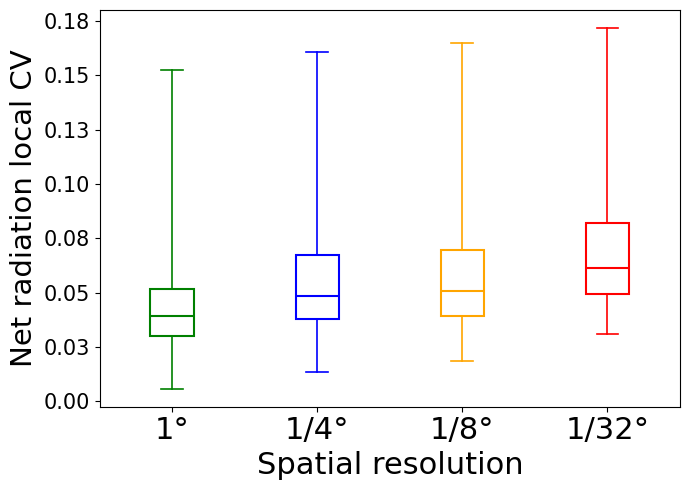

In [21]:
plt.figure(figsize=(7,5))
box = plt.boxplot(net_radiation_cv_stats, patch_artist=True, widths=0.3, showfliers=False, whis=[1,99])
resolutions = ['1°', '1/4°', '1/8°', '1/32°']
resolution_colors = ['green','blue','orange','red'] 
resolution_labels = [f'1° ({window_1deg}x{window_1deg})', 
                     f'1/4° ({window_14deg}x{window_14deg})',
                         f'1/8° ({window_18deg}x{window_18deg})', 
                         f'1/32° ({window_132deg}x{window_132deg})']
x_positions = range(1, len(net_radiation_cv_stats) + 1) 
for i, patch in enumerate(box['boxes']):
    resolution_color = resolution_colors[i % 4]  
    patch.set_facecolor('none') 
    patch.set_edgecolor(resolution_color)
    patch.set_linewidth(1.5)

for i, (whisker, cap) in enumerate(zip(box['whiskers'], box['caps'])):
    resolution_color = resolution_colors[(i // 2) % 4]
    whisker.set_color(resolution_color)
    whisker.set_linewidth(1.2)
    cap.set_color(resolution_color)
    cap.set_linewidth(1.2)

for i, median in enumerate(box['medians']):
    resolution_color = resolution_colors[i % 4]
    median.set_color(resolution_color)
    median.set_linewidth(1.5)

import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(edgecolor=color, label=res, fill=False) for color, res in zip(resolution_colors, resolution_labels)]
# plt.legend(handles=legend_patches, loc='upper left',fontsize=14)
from matplotlib.ticker import FormatStrFormatter

ax = plt.gca() 
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xticks(x_positions,resolutions,fontsize=22)
plt.yticks(fontsize=15)
plt.xlabel('Spatial resolution',fontsize=22)
plt.ylabel('Net radiation local CV',fontsize=21)
plt.tight_layout()

___

### Figure 9b[3] & 9d[3]

___

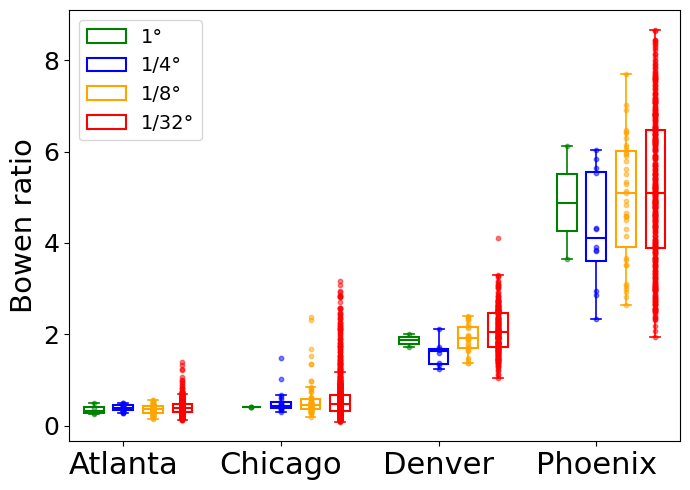

In [22]:
atlanta=[atl_1deg_bowen_ratio,atl_025deg_bowen_ratio,atl_14km_bowen_ratio,atl_1d32deg_bowen_ratio]
chicago=[chi_1deg_bowen_ratio,chi_025deg_bowen_ratio,chi_14km_bowen_ratio,chi_1d32deg_bowen_ratio]
denver=[dnv_1deg_bowen_ratio,dnv_025deg_bowen_ratio,dnv_14km_bowen_ratio,dnv_1d32deg_bowen_ratio]
phoenix=[phx_1deg_bowen_ratio,phx_025deg_bowen_ratio,phx_14km_bowen_ratio,phx_1d32deg_bowen_ratio]
all_data = atlanta+chicago + denver + phoenix

custom_data = []
for dataset in all_data:
    lower = np.percentile(dataset, 1)  # 1st percentile
    upper = np.percentile(dataset, 99)  # 99th percentile
    filtered_data = dataset[(dataset >= lower) & (dataset <= upper)]
    custom_data.append(filtered_data)
    
groups = [atlanta, chicago, denver, phoenix]
group_labels = ['Atlanta','Chicago', 'Denver', 'Phoenix']
all_data = sum(groups, [])  
resolutions = ['1°', '1/4°', '1/8°', '1/32°']
resolution_colors = ['green','blue','orange','red']  

group_gap = 3.2
positions = []
for i, group in enumerate(groups):
    group_start = i * group_gap + 1
    positions.extend([group_start + j * 0.6 for j in range(len(group))])

plt.figure(figsize=(7,5))
box = plt.boxplot(all_data, positions=positions, patch_artist=True, widths=0.4, showfliers=False)

for i, patch in enumerate(box['boxes']):
    resolution_color = resolution_colors[i % 4]  
    patch.set_facecolor('none') 
    patch.set_edgecolor(resolution_color)
    patch.set_linewidth(1.5)

for i, (whisker, cap) in enumerate(zip(box['whiskers'], box['caps'])):
    resolution_color = resolution_colors[(i // 2) % 4]
    whisker.set_color(resolution_color)
    whisker.set_linewidth(1.2)
    cap.set_color(resolution_color)
    cap.set_linewidth(1.2)

for i, median in enumerate(box['medians']):
    resolution_color = resolution_colors[i % 4]
    median.set_color(resolution_color)
    median.set_linewidth(1.5)

for i, dataset in enumerate(all_data):
    resolution_color = resolution_colors[i % 4] 
    x = np.random.normal(positions[i], 0.0, size=len(dataset))
    plt.scatter(x, dataset, alpha=0.5, s=10, color=resolution_color)

legend_patches = [
    mpatches.Patch(facecolor='none', edgecolor=color, label=res, linewidth=1.5)
    for color, res in zip(resolution_colors, resolutions)
]

plt.legend(handles=legend_patches, loc='upper left', fontsize=14)

group_tick_positions = [group[0] + (positions[1] - positions[0]) for group in np.array_split(positions, len(groups))]
plt.xticks(group_tick_positions, group_labels,fontsize=22)
plt.yticks(fontsize=18)
plt.ylabel(r'Bowen ratio',fontsize=21)
plt.tight_layout()

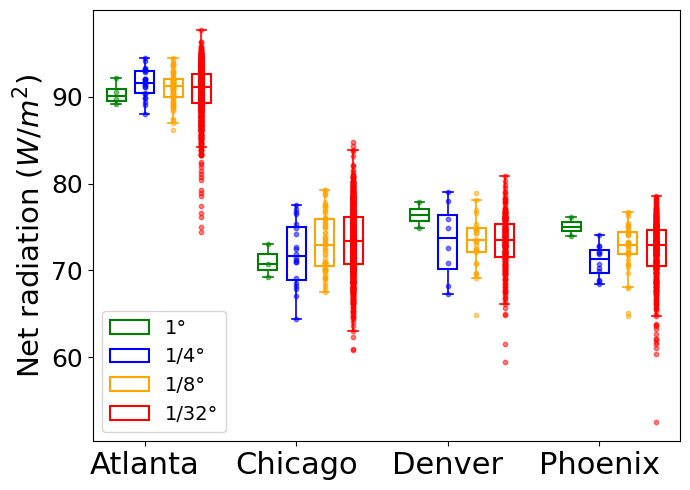

In [23]:
atlanta=[atl_1deg_net_radiation,atl_025deg_net_radiation,atl_14km_net_radiation,atl_1d32deg_net_radiation]
chicago=[chi_1deg_net_radiation,chi_025deg_net_radiation,chi_14km_net_radiation,chi_1d32deg_net_radiation]
denver=[dnv_1deg_net_radiation,dnv_025deg_net_radiation,dnv_14km_net_radiation,dnv_1d32deg_net_radiation]
phoenix=[phx_1deg_net_radiation,phx_025deg_net_radiation,phx_14km_net_radiation,phx_1d32deg_net_radiation]
all_data = atlanta+chicago + denver + phoenix

custom_data = []
for dataset in all_data:
    lower = np.percentile(dataset, 1)  # 1st percentile
    upper = np.percentile(dataset, 99)  # 99th percentile
    filtered_data = dataset[(dataset >= lower) & (dataset <= upper)]
    custom_data.append(filtered_data)
    
groups = [atlanta, chicago, denver, phoenix]
group_labels = ['Atlanta','Chicago', 'Denver', 'Phoenix']
all_data = sum(groups, [])  
resolutions = ['1°', '1/4°', '1/8°', '1/32°']
resolution_colors = ['green','blue','orange','red']  

group_gap = 3.2
positions = []
for i, group in enumerate(groups):
    group_start = i * group_gap + 1
    positions.extend([group_start + j * 0.6 for j in range(len(group))])

plt.figure(figsize=(7,5))
box = plt.boxplot(all_data, positions=positions, patch_artist=True, widths=0.4, showfliers=False)

for i, patch in enumerate(box['boxes']):
    resolution_color = resolution_colors[i % 4]  
    patch.set_facecolor('none') 
    patch.set_edgecolor(resolution_color)
    patch.set_linewidth(1.5)

for i, (whisker, cap) in enumerate(zip(box['whiskers'], box['caps'])):
    resolution_color = resolution_colors[(i // 2) % 4]
    whisker.set_color(resolution_color)
    whisker.set_linewidth(1.2)
    cap.set_color(resolution_color)
    cap.set_linewidth(1.2)

for i, median in enumerate(box['medians']):
    resolution_color = resolution_colors[i % 4]
    median.set_color(resolution_color)
    median.set_linewidth(1.5)

for i, dataset in enumerate(all_data):
    resolution_color = resolution_colors[i % 4] 
    x = np.random.normal(positions[i], 0.0, size=len(dataset))
    plt.scatter(x, dataset, alpha=0.5, s=10, color=resolution_color)

legend_patches = [
    mpatches.Patch(facecolor='none', edgecolor=color, label=res, linewidth=1.5)
    for color, res in zip(resolution_colors, resolutions)
]

plt.legend(handles=legend_patches, loc='lower left', fontsize=14)

group_tick_positions = [group[0] + (positions[1] - positions[0]) for group in np.array_split(positions, len(groups))]
plt.xticks(group_tick_positions, group_labels,fontsize=22)
plt.yticks(fontsize=18)
plt.ylabel(r'Net radiation ($W/m^2$)',fontsize=21)
plt.tight_layout()

___

### Figure 9b[4] & 9d[4]

___


Information loss at different resolutions:

R1 (Humid Subtropical):
1/8° resolution: 15.5%
1/4° resolution: 34.3%
1° resolution: 40.8%

R2 (Continental):
1/8° resolution: 21.7%
1/4° resolution: 45.8%
1° resolution: 64.5%

R3 (Semi-arid):
1/8° resolution: 4.4%
1/4° resolution: 18.2%
1° resolution: 18.4%

R4 (Arid):
1/8° resolution: 3.1%
1/4° resolution: 1.7%
1° resolution: 12.0%


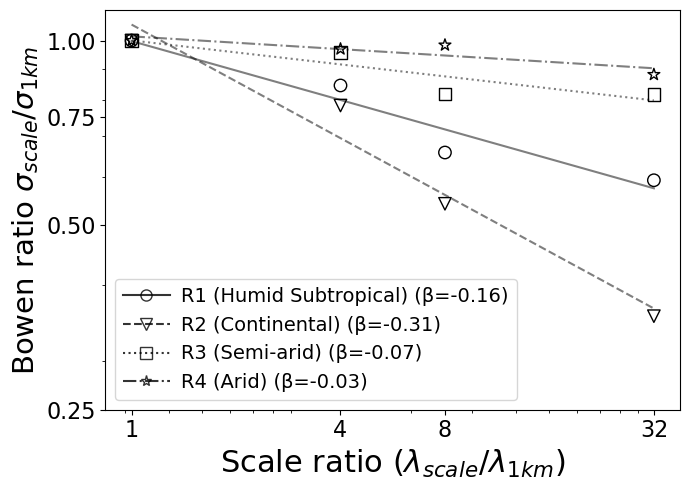

In [14]:
from matplotlib.lines import Line2D
region_styles = {
    'R1': {'color': 'green', 'name': 'R1 (Humid Subtropical)'},
    'R2': {'color': 'blue', 'name': 'R2 (Continental)'},
    'R3': {'color': 'orange', 'name': 'R3 (Semi-arid)'},
    'R4': {'color': 'red', 'name': 'R4 (Arid)'}
}
markers=['o','v','s','*']
linestyles=['solid','dashed','dotted','dashdot']

fig, ax = plt.subplots(figsize=(7,5))
scale_ratios = [1/32, 1/8, 1/4, 1]  # Finest to coarsest

legend_handles = []

for i,region_name in enumerate(bowen_ratio_std_stats_by_region.keys()):
    std_values = [
        np.nanmean(bowen_ratio_std_stats_by_region[region_name]['1/32deg']),
        np.nanmean(bowen_ratio_std_stats_by_region[region_name]['1/8deg']),
        np.nanmean(bowen_ratio_std_stats_by_region[region_name]['1/4deg']),
        np.nanmean(bowen_ratio_std_stats_by_region[region_name]['1deg'])
    ]
    std_ratios = [std/std_values[0] for std in std_values]
    
    log_scales = np.log(scale_ratios)
    log_ratios = np.log(std_ratios)

    slope, intercept, r_value, p_value, std_err = stats.linregress(log_scales, log_ratios)
    
    style = region_styles[region_name]
    ax.scatter(scale_ratios, std_ratios, facecolor='none', edgecolor='black', 
              marker=markers[i], s=80, label=f"{style['name']} (β={slope:.2f})")
    
    x_fit = np.linspace(min(scale_ratios), max(scale_ratios), 100)
    y_fit = np.exp(slope * np.log(x_fit) + intercept)
    ax.plot(x_fit, y_fit, ls=linestyles[i], color='black', alpha=0.5)

    h = Line2D([0], [0],
                   marker=markers[i],
                   linestyle=linestyles[i],
                   color='black', alpha=0.8,
                   markerfacecolor='none', markeredgecolor='black',
                   linewidth=1.5, markersize=8,
                   label=f"{style['name']} (β={slope:.2f})")
    legend_handles.append(h)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(scale_ratios)
ax.set_xticklabels([1, 4, 8, 32], fontsize=16)

y_ticks = [0.25, 0.5, 0.75, 1.0]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{y:.2f}' for y in y_ticks], fontsize=16)
ax.yaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_major_locator(plt.FixedLocator(y_ticks))
ax.set_xlabel(r'Scale ratio ($\lambda_{scale}/\lambda_{1km}$)', fontsize=22)
ax.set_ylabel('Bowen ratio $\sigma_{scale}/\sigma_{1km}$', fontsize=21)
# ax.legend(fontsize=14)
ax.legend(handles=legend_handles, fontsize=14,
          handlelength=2.4, handletextpad=0.6, markerfirst=True)
plt.tight_layout()

print("\nInformation loss at different resolutions:")
for region_name, std_stats in bowen_ratio_std_stats_by_region.items():
    std_finest = np.nanmean(std_stats['1/32deg'])
    info_loss = {
        '1/8deg': (1 - np.nanmean(std_stats['1/8deg'])/std_finest)*100,
        '1/4deg': (1 - np.nanmean(std_stats['1/4deg'])/std_finest)*100,
        '1deg': (1 - np.nanmean(std_stats['1deg'])/std_finest)*100
    }
    print(f"\n{region_styles[region_name]['name']}:")
    print(f"1/8° resolution: {info_loss['1/8deg']:.1f}%")
    print(f"1/4° resolution: {info_loss['1/4deg']:.1f}%")
    print(f"1° resolution: {info_loss['1deg']:.1f}%")


Information loss at different resolutions:

R1 (Humid Subtropical):
1/8° resolution: 12.0%
1/4° resolution: 17.9%
1° resolution: 27.5%

R2 (Continental):
1/8° resolution: 15.5%
1/4° resolution: 17.3%
1° resolution: 30.3%

R3 (Semi-arid):
1/8° resolution: 26.1%
1/4° resolution: 31.5%
1° resolution: 60.5%

R4 (Arid):
1/8° resolution: 18.3%
1/4° resolution: 21.5%
1° resolution: 44.0%


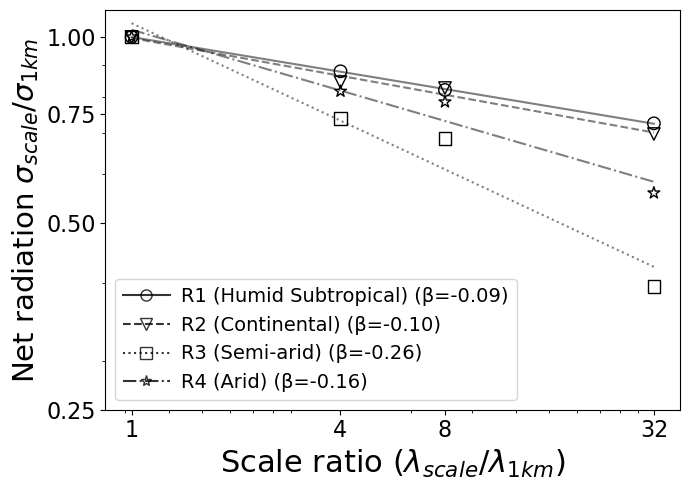

In [17]:
fig, ax = plt.subplots(figsize=(7,5))
scale_ratios = [1/32, 1/8, 1/4, 1]  # Finest to coarsest

legend_handles = []

for i,region_name in enumerate(net_radiation_std_stats_by_region.keys()):
    std_values = [
        np.nanmean(net_radiation_std_stats_by_region[region_name]['1/32deg']),
        np.nanmean(net_radiation_std_stats_by_region[region_name]['1/8deg']),
        np.nanmean(net_radiation_std_stats_by_region[region_name]['1/4deg']),
        np.nanmean(net_radiation_std_stats_by_region[region_name]['1deg'])
    ]
    std_ratios = [std/std_values[0] for std in std_values]
    
    log_scales = np.log(scale_ratios)
    log_ratios = np.log(std_ratios)

    slope, intercept, r_value, p_value, std_err = stats.linregress(log_scales, log_ratios)
    
    style = region_styles[region_name]
    ax.scatter(scale_ratios, std_ratios, facecolor='none', edgecolor='black', 
              marker=markers[i], s=80, label=f"{style['name']} (β={slope:.2f})")
    
    x_fit = np.linspace(min(scale_ratios), max(scale_ratios), 100)
    y_fit = np.exp(slope * np.log(x_fit) + intercept)
    ax.plot(x_fit, y_fit, ls=linestyles[i], color='black', alpha=0.5)

    h = Line2D([0], [0],
                   marker=markers[i],
                   linestyle=linestyles[i],
                   color='black', alpha=0.8,
                   markerfacecolor='none', markeredgecolor='black',
                   linewidth=1.5, markersize=8,
                   label=f"{style['name']} (β={slope:.2f})")
    legend_handles.append(h)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(scale_ratios)
ax.set_xticklabels([1, 4, 8, 32], fontsize=16)

y_ticks = [0.25, 0.5, 0.75, 1.0]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{y:.2f}' for y in y_ticks], fontsize=16)
ax.yaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_major_locator(plt.FixedLocator(y_ticks))
ax.set_xlabel(r'Scale ratio ($\lambda_{scale}/\lambda_{1km}$)', fontsize=22)
ax.set_ylabel('Net radiation $\sigma_{scale}/\sigma_{1km}$', fontsize=21)
# ax.legend(fontsize=14)
ax.legend(handles=legend_handles, fontsize=14,
          handlelength=2.4, handletextpad=0.6, markerfirst=True)
plt.tight_layout()

print("\nInformation loss at different resolutions:")
for region_name, std_stats in net_radiation_std_stats_by_region.items():
    std_finest = np.nanmean(std_stats['1/32deg'])
    info_loss = {
        '1/8deg': (1 - np.nanmean(std_stats['1/8deg'])/std_finest)*100,
        '1/4deg': (1 - np.nanmean(std_stats['1/4deg'])/std_finest)*100,
        '1deg': (1 - np.nanmean(std_stats['1deg'])/std_finest)*100
    }
    print(f"\n{region_styles[region_name]['name']}:")
    print(f"1/8° resolution: {info_loss['1/8deg']:.1f}%")
    print(f"1/4° resolution: {info_loss['1/4deg']:.1f}%")
    print(f"1° resolution: {info_loss['1deg']:.1f}%")